<a href="https://colab.research.google.com/github/keirkwame/axionEmu/blob/main/Open_access_version_of_4e5_Planck_2018_3x2pt_analysis_(ma%3D_29).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as sps
import getdist
from tqdm import trange

#Install ACT DR4 likelihood
import pyactlike

# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
print('using', device, 'device \n')


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
using gpu:0 device 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install git+https://github.com/justinalsing/affine.git

In [ ]:
import affine

In [ ]:
from axionEmu.cosmopower.cosmopower_NN import cosmopower_NN

In [ ]:
from axionEmu.cosmopower.cosmopower_PCAplusNN import cosmopower_PCAplusNN

In [ ]:
##DM-like axions (m > 5.e-27 eV)

tt_emu_model_ax = cosmopower_NN(restore=True,
                                restore_filename='/home/keir/Software/axionEmu/axion_CMB_models/TT_cp_NN_5e5_DM_t2' #TT_lensed_NL_NN_axion'
                               )

te_emu_model_ax = cosmopower_PCAplusNN(restore=True,
                                restore_filename='/home/keir/Software/axionEmu/axion_CMB_models/TE_cp_PCAplusNN_5e5_DM_t2' #TE_lensed_NL_NN_axion'
                               )

ee_emu_model_ax = cosmopower_NN(restore=True,
                                restore_filename='/home/keir/Software/axionEmu/axion_CMB_models/EE_cp_NN_5e5_DM_t2' #EE_lensed_NL_NN_axion'
                                )

In [ ]:
##DE-like axions (m < 5.e-27 eV)

tt_emu_model_ax = cosmopower_NN(restore=True,
                                restore_filename='/home/keir/Software/axionEmu/axion_CMB_models/TT_cp_NN_5e5_DE_t2'
                               )

te_emu_model_ax = cosmopower_PCAplusNN(restore=True,
                                restore_filename='/home/keir/Software/axionEmu/axion_CMB_models/TE_cp_PCAplusNN_5e5_DE_t2'
                               )

ee_emu_model_ax = cosmopower_NN(restore=True,
                                restore_filename='/home/keir/Software/axionEmu/axion_CMB_models/EE_cp_NN_5e5_DE_t2'
                                )

In [ ]:
##Axion lensing model for ACT DR6
pp_emu_model_ax = cosmopower_NN(restore=True, restore_filename='/home/keir/Software/axionEmu/phi_NN_axion')


In [ ]:
cosmo_params = dict()
cosmo_params['h'] = np.array([0.7])
cosmo_params['tau_reio'] = np.array([0.055])
cosmo_params['omega_b'] = np.array([0.0224])
cosmo_params['omega_cdm'] = np.array([0.12])
cosmo_params['n_s'] = np.array([0.96])
cosmo_params['omega_ax'] =np.array([0.001])
cosmo_params['log10ma'] = np.array([7],dtype='float64')
cosmo_params['ln10A_s'] = np.array([3.48])

In [ ]:
len([list(cosmo_params.keys())])

In [ ]:
b = pp_emu_model_ax.predictions_np(cosmo_params)

In [ ]:
b[0].shape

In [ ]:
#Testing power spectrum prediction
plt.plot(b[0])

In [ ]:
#Import WMAP likelihood
from wmaplike import WMAPLike


In [ ]:
import multiprocessing as mp
mp.set_start_method('spawn')
import copy as cp
from get_likelihood_WMAP import get_likelihood_WMAP


In [ ]:
##WMAP likelihood
# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_cdm':    [1.e-32, 0.14, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.065, 0.015,   'gaussian'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [1.61,  3.4,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                         'omega_ax': [1.e-32, 0.14,  'uniform'],
                         'yp':     [0.9, 1.1,  'uniform']
                         }
fixed = {'log10ma': 7.0} #, 'omega_ax': 9.794086321726434e-10}

#Create prior arrays
prior_min = np.array([0.0174, 1.e-32, 0.55, 0.01, 0.86, 1.61, 1.e-32, 0.9]) #, 1.e-32, 0.9])
prior_max = np.array([0.0274, 0.14, 0.82, 0.26, 1.07, 3.4, 0.14, 1.1]) #, 0.01, 1.1])

#Create Gaussian prior function
gaussian_obj = sps.norm(loc=0.065, scale=0.015)

#Create WMAP likelihood object
like = WMAPLike({'packages_path': '/tmp/SPT_packages', "use_lowl_TT" : True, "use_highl_TT" : True,
                        "use_highl_TE" : True, "use_highl_TB" : False, "use_lowl_pol" : False,
                        "use_lowl_TBEB" : False, "use_highl_TT_beam_ptsrc" : False, "use_sz" : False,
                        "debug" : False, 'temin': 24, 'ttmax': 1200, 'temax': 800})

def log_prob_ax(theta):
  """Posterior probability given WMAP likelihood and emulated theory."""
  print('Calling likelihood function')
  emulators=[tt_emu_model_ax, te_emu_model_ax]
  ell=np.linspace(2,6000,5999)

  emulator_tt, emulator_te = emulators
  ell = ell.reshape(1, -1)

  #Create theta dictionary
  theta_dict = {key: theta[:, i].numpy() for i, key in enumerate(parameters_and_priors_ax.keys())}
  #yp = theta_dict['yp']
  #theta_dict.pop('yp', None)
  theta_all_dict = {**theta_dict, **fixed}
  for key in fixed.keys():
    theta_all_dict[key] = np.array([theta_all_dict[key],] * theta.shape[0])
  #print(theta_all_dict)

  #Add fixed parameters
  '''theta_fixed = np.zeros((theta.get_shape().as_list()[0], len(fixed.keys())))
  for i, key in enumerate(fixed.keys()):
    theta_fixed[:, i] = np.array([fixed[key],] * theta.get_shape().as_list()[0])
  theta_all = tf.concat([theta, tf.convert_to_tensor(theta_fixed)], 1)
  '''

  #Get emulated theory vectors
  d_ell_tt = emulator_tt.ten_to_predictions_np(theta_all_dict) * ell * (ell + 1.) / (2. * np.pi) * ((2.7255e+6)**2) #Convert to uK^2 #Check conversion!
  #print(d_ell_tt.shape, d_ell_tt)
  d_ell_te = emulator_te.predictions_np(theta_all_dict) * ell * (ell + 1.) / (2. * np.pi) * ((2.7255e+6)**2) #Convert to uK^2
  #print(d_ell_te.shape, d_ell_te)
  #d_ell_ee = emulator_ee.ten_to_predictions_np(theta_all_dict) * ell * (ell + 1.) / (2. * np.pi) * ((2.7255e+6)**2) #Convert to uK^2
  #print(d_ell_ee.shape, d_ell_ee)

  #Get likelihood
  #likelihood = np.ones(d_ell_tt.shape[0]) * -1.e+10
  d_ell_dict = [{d_ell_name: np.zeros(1300) for d_ell_name in [ "tt", "te"]} for i in range(d_ell_tt.shape[0])] #* d_ell_tt.shape[0] #ell.shape[1] + 2
  #print(d_ell_dict[0])

  for i in range(d_ell_tt.shape[0]):
    #print('Params #', i)
    d_ell_dict[i]['likelihood_object'] = like
    if np.sum(theta[i].numpy() > prior_max) + np.sum(theta[i].numpy() < prior_min):
      #Set power spectra to zero
      d_ell_dict[i]['zero_prior'] = True
      #print('Prior = zero', d_ell_dict[i]['zero_prior'])
    else:
      #Put angular power spectra into dictionary
      d_ell_dict[i]['tt'][2:] = d_ell_tt[i][:1300-2]
      d_ell_dict[i]['te'][2:] = d_ell_te[i][:1300-2]
      d_ell_dict[i]['zero_prior'] = False
      #print('Prior > zero', d_ell_dict[i]['zero_prior'])

  #print(d_ell_dict)

  #print('Evaluating likelihood #', i)
  #likelihood[i], _ = like.loglike(d_ell_dict)
  #Multiprocessing version of getting likelihood
  with mp.Pool(processes=d_ell_tt.shape[0]) as pool:
      likelihood = np.array(pool.map(get_likelihood_WMAP, d_ell_dict))
  pool.close()
  pool.join()

  #Apply any Gaussian prior
  #print(np.log(gaussian_obj.pdf(theta_all_dict['tau_reio'])))
  likelihood += np.log(gaussian_obj.pdf(theta_all_dict['tau_reio']))

  #print(likelihood)
  likelihood_tf = tf.convert_to_tensor(likelihood, np.float32)
  #print(likelihood_tf)

  return likelihood_tf

FIDUCIAL = np.reshape(np.array([ 0.022242,  0.1197,  0.673,  0.1,  0.9658,  3.0753, 0.005, 1.0]).astype('float32'), (1, 8))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3, 1E-4, 1.E-3]).astype('float32'), (1,8))


In [ ]:
##Test WMAP likelihood
theta_test = tf.convert_to_tensor(np.array([[0.02153, 0.1178, 0.679, 0.065, 1.008, 3.05, 0.005, 1.0], [0.021, 0.11, 0.71, 0.11, 0.91, 3.01, 0.001, 1.0], [0.001, 0.11, 0.71, 0.11, 0.91, 3.01, 0.001, 1.0]]), np.float32)
print(theta_test)
likelihood_test = log_prob_ax(theta_test)
print('likelihood_test =', likelihood_test)
#print(d_ell_dict)


In [ ]:
##ACT DR4 likelihood
# parameters of the analysis, and their priors
'''parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_cdm':    [1.e-32, 0.14, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.065, 0.015,   'gaussian'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [1.61,  3.4,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                          'omega_ax': [1.e-32, 0.14,  'uniform'],
                         'yp':     [0.9, 1.1,  'uniform'],
                         }
fixed = {'log10ma': 7.0} #, 'omega_ax': 9.794086321726434e-10}

#Create prior arrays
prior_min = np.array([0.0174, 1.e-32, 0.55, 0.01, 0.86, 1.61, 1.e-32, 0.9])
prior_max = np.array([0.0274, 0.14, 0.82, 0.26, 1.07, 3.4, 0.14, 1.1])

#Create Gaussian prior function
gaussian_obj = sps.norm(loc=0.065, scale=0.015)'''

#@tf.function #Can't use graph mode until re-write likelihood in tf
def log_prob_ax_ACT_DR4(theta):
  """Posterior probability given ACT DR4 likelihood and emulated theory."""
  emulators=[tt_emu_model_ax, te_emu_model_ax, ee_emu_model_ax]
  ell=np.linspace(2,6000,5999)

  emulator_tt, emulator_te, emulator_ee = emulators
  ell = ell.reshape(1, -1)
  like = pyactlike.ACTPowerSpectrumData()
  #like.tt_lmax = int(np.max(ell))

  #Create theta dictionary
  theta_dict = {key: theta[:, i].numpy() for i, key in enumerate(parameters_and_priors_ax.keys())}
  yp = theta_dict['yp']
  theta_dict.pop('yp', None)
  theta_all_dict = {**theta_dict, **fixed}
  for key in fixed.keys():
    theta_all_dict[key] = np.array([theta_all_dict[key],] * theta.shape[0])
  #print(theta_all_dict)

  #Add fixed parameters
  '''theta_fixed = np.zeros((theta.get_shape().as_list()[0], len(fixed.keys())))
  for i, key in enumerate(fixed.keys()):
    theta_fixed[:, i] = np.array([fixed[key],] * theta.get_shape().as_list()[0])
  theta_all = tf.concat([theta, tf.convert_to_tensor(theta_fixed)], 1)
  '''

  #Get emulated theory vectors
  d_ell_tt = emulator_tt.ten_to_predictions_np(theta_all_dict) * ell * (ell + 1.) / (2. * np.pi) * ((2.7255e+6)**2) #Convert to uK^2 #Check conversion!
  #print(d_ell_tt.shape, d_ell_tt)
  d_ell_te = emulator_te.predictions_np(theta_all_dict) * ell * (ell + 1.) / (2. * np.pi) * ((2.7255e+6)**2) #Convert to uK^2
  #print(d_ell_te.shape, d_ell_te)
  d_ell_ee = emulator_ee.ten_to_predictions_np(theta_all_dict) * ell * (ell + 1.) / (2. * np.pi) * ((2.7255e+6)**2) #Convert to uK^2
  #print(d_ell_ee.shape, d_ell_ee)

  #Get likelihood
  #likelihood = np.array([like.loglike(d_ell_tt[i], d_ell_te[i], d_ell_ee[i], yp[i]**2.) for i in range(d_ell_tt.shape[0])])
  likelihood = np.ones(d_ell_tt.shape[0]) * -1.e+10
  for i in range(d_ell_tt.shape[0]):
    if np.sum(theta[i].numpy() > prior_max) + np.sum(theta[i].numpy() < prior_min):
      pass
    else:
      likelihood[i] = like.loglike(d_ell_tt[i], d_ell_te[i], d_ell_ee[i], yp[i])

  #Apply any Gaussian prior
  #print(np.log(gaussian_obj.pdf(theta_all_dict['tau_reio'])))
  #likelihood += np.log(gaussian_obj.pdf(theta_all_dict['tau_reio']))

  #print(likelihood)
  likelihood_tf = tf.convert_to_tensor(likelihood, np.float32)
  #print(likelihood_tf)

  return likelihood_tf

FIDUCIAL = np.reshape(np.array([ 0.022242,  0.1197,  0.673,  0.1,  0.9658,  3.0753, 0.005, 1.0]).astype('float32'), (1, 8))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3, 1E-4, 1E-4]).astype('float32'), (1,8))


In [ ]:
##Test ACT likelihood
theta_test = tf.convert_to_tensor(np.array([[0.02153, 0.1178, 0.679, 0.065, 1.008, 3.05, 0.005, 1.0008], [0.021, 0.11, 0.71, 0.11, 0.91, 3.01, 0.005, 1.01], [0.001, 0.11, 0.71, 0.11, 0.91, 3.01, 0.001, 1.01]]), np.float32)
print(theta_test)
likelihood_test = log_prob_ax_ACT_DR4(theta_test)
print('likelihood_test =', likelihood_test)


In [ ]:
import act_dr6_lenslike as alike


In [ ]:
##ACT DR6 likelihood
# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.019, 0.026, 'uniform'],
                         'omega_cdm':    [0.0003, 0.14, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.065, 0.015,   'gaussian'],
                          #'tau_reio':     [0.02, 0.12,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [1.610,  3.258,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                         'omega_ax': [1.e-32, 0.13,  'uniform'],
                          #'yp':     [0.9, 1.1,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian']
                         }
fixed = {'log10ma': 8.0} #, 'omega_ax': 9.794086321726434e-10} #, 'tau_reio': 0.07}

#Create prior arrays
prior_min = np.array([0.019, 0.0003, 0.55, 0.02, 0.86, 1.610, 1.e-32, 0.95])
prior_max = np.array([0.026, 0.14, 0.82, 0.12, 1.07, 3.258, 0.13, 1.05])

#Create Gaussian prior function
#gaussian_obj = sps.norm(loc=0.065, scale=0.015) #tau
#gaussian_obj_ns = sps.norm(loc=0.96, scale=0.02)
#gaussian_obj_baryon = sps.norm(loc=0.02233, scale=0.00036)

#Load ACT DR6 data
variant = 'act_extended'
lens_only = False
like_corrections = False
trim_lmax = 1450
data_dict = alike.load_data(variant, lens_only=lens_only, like_corrections=like_corrections, trim_lmax=trim_lmax)

#@tf.function #Can't use graph mode until re-write likelihood in tf
def log_prob_ax(theta):
  """Posterior probability given ACT DR6 likelihood and emulated theory."""
  emulators=[tt_emu_model_ax, te_emu_model_ax, ee_emu_model_ax, pp_emu_model_ax]
  ell=np.linspace(2,1500, 1499)
  ell_primary = np.linspace(2,6000, 5999)

  emulator_tt, emulator_te, emulator_ee, emulator_pp = emulators
  ell = ell.reshape(1, -1)
  ell_primary = ell_primary.reshape(1, -1)

  #Create theta dictionary
  theta_dict = {key: theta[:, i].numpy() for i, key in enumerate(parameters_and_priors_ax.keys())}
  #yp = theta_dict['yp']
  #theta_dict.pop('yp', None)
  theta_all_dict = {**theta_dict, **fixed}
  for key in fixed.keys():
    theta_all_dict[key] = np.array([theta_all_dict[key],] * theta.shape[0])
  #print(theta_all_dict)

  #Remove A_Planck
  #del theta_all_dict['A_planck']

  #Get emulated theory vectors
  c_ell_tt = emulator_tt.ten_to_predictions_np(theta_all_dict) * ((2.7255e+6)**2) #Convert to uK^2 #Check conversion!
  #print(d_ell_tt.shape, d_ell_tt)
  c_ell_te = emulator_te.predictions_np(theta_all_dict) * ((2.7255e+6)**2) #Convert to uK^2
  #print(d_ell_te.shape, d_ell_te)
  c_ell_ee = emulator_ee.ten_to_predictions_np(theta_all_dict) * ((2.7255e+6)**2) #Convert to uK^2
  #print(d_ell_ee.shape, d_ell_ee)
  c_ell_kk = emulator_pp.ten_to_predictions_np(theta_all_dict) * np.pi / 2.

  #Get likelihood
  #likelihood = np.array([like.loglike(d_ell_tt[i], d_ell_te[i], d_ell_ee[i], yp[i]**2.) for i in range(d_ell_tt.shape[0])])
  likelihood = np.ones(c_ell_kk.shape[0]) * -1.e+10
  for i in range(c_ell_kk.shape[0]):
    if np.sum(theta[i].numpy() > prior_max) + np.sum(theta[i].numpy() < prior_min):
      pass
    else:
      #print(ell[0].shape, c_ell_kk[i].shape)
      likelihood[i] = alike.generic_lnlike(data_dict, ell[0], c_ell_kk[i], ell_primary[0], c_ell_tt[i], c_ell_ee[i], c_ell_te[i], c_ell_tt[0], trim_lmax=trim_lmax) #like.loglike(d_ell_tt[i], d_ell_te[i], d_ell_ee[i], yp[i])

  #Apply any Gaussian prior
  #print(np.log(gaussian_obj.pdf(theta_all_dict['tau_reio'])))
  #likelihood += np.log(gaussian_obj.pdf(theta_all_dict['tau_reio']))
  #likelihood += np.log(gaussian_obj_ns.pdf(theta_all_dict['n_s']))
  #likelihood += np.log(gaussian_obj_baryon.pdf(theta_all_dict['omega_b']))

  #print(likelihood)
  likelihood_tf = tf.convert_to_tensor(likelihood, np.float32)
  #print(likelihood_tf)

  return likelihood_tf

FIDUCIAL = np.reshape(np.array([ 0.022242,  0.1197,  0.673, 0.065,  0.9658,  3.0753, 0.01, 1.0]).astype('float32'), (1, 8))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2, 1E-4,   1E-3,    1E-3, 1.E-4, 1E-4]).astype('float32'), (1,8))


In [ ]:
##Test ACT likelihood
theta_test = tf.convert_to_tensor(np.array([[0.02153, 0.1178, 0.679, 0.065, 1.008, 3.05, 0.1, 1.0], [0.021, 0.11, 0.71, 0.065, 1.008, 3.01, 0.1, 1.0], [0.0191, 0.11, 0.71, 0.065, 0.91, 3.01, 0.001, 1.0]]), np.float32)
print(theta_test)
likelihood_test = log_prob_ax(theta_test)
print('likelihood_test =', likelihood_test)


In [ ]:
##m = 1e-25 axion
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/home/keir/Software/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
'''parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_cdm':    [0.0003, 0.149, 'uniform'],
                         'h':            [0.64, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          'omega_ax': [1e-32, 0.09,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
# fixed_1 = {'log10ma': 3.0, 'omega_ax': 9.794086321726434e-10}
fixed = {'log10ma': 7.0}'''
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##m = 1e-25 axion
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.1197,  0.673,  0.055,  0.9658,  3.0753,  0.05, 1.0080]).astype('float32'), (1, 8))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,  1E-2, 1E-4]).astype('float32'), (1,8))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
##m = 1e-28 axion
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/content/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_lamda':    [0.16, 0.36, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                          'omega_ax': [1e-32, 0.01,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
# fixed_1 = {'log10ma': 3.0, 'omega_ax': 9.794086321726434e-10}
fixed = {'log10ma': 4.0}
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##m = 1e-28 axion
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.3107,  0.673,  0.1,  0.9658,  3.0753,  0.005, 1.0080]).astype('float32'), (1, 8))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-3,     1E-2,   1E-3,   1E-3,    1E-3,  1E-3, 1E-4]).astype('float32'), (1,8))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
##m = 1e-30 axion
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/content/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_lamda':    [0.16, 0.36, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                          'omega_ax': [1e-32, 0.01,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
# fixed_1 = {'log10ma': 3.0, 'omega_ax': 9.794086321726434e-10}
fixed = {'log10ma': 2.0}
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##m = 1e-30 axion
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.3107,  0.673,  0.1,  0.9658,  3.0753,  0.005, 1.0080]).astype('float32'), (1, 8))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-3,     1E-2,   1E-3,   1E-3,    1E-3,  1E-3, 1E-4]).astype('float32'), (1,8))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
##LCDM
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/home/keir/Software/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
'''parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_cdm':    [0.0003, 0.149, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          #'log10ma': [2.9, 3.1, 'uniform'], #10^32ma(ma in unit of eV)
                          #'omega_ax': [1e-32, 0.01,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
fixed = {'log10ma': 2.0, 'omega_ax': 9.794086321726434e-10}'''
#fixed = {'log10ma': 2.0}
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax,
                                  use_low_ell_bins=False)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##LCDM
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.1197,  0.673,  0.1,  0.9658,  3.0753,  1.0080]).astype('float32'), (1, 7))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,  1E-4]).astype('float32'), (1,7))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
##All axion masses
# path to the tf_planck2018_lite likelihood
from axionEmu.tf_planck2018_lite_mod import tf_planck2018_lite
tf_planck2018_lite_path = '/content/axionEmu/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors_ax = {'omega_b':      [0.0174, 0.0274, 'uniform'],
                         'omega_lamda':    [0.16, 0.36, 'uniform'],
                         'h':            [0.55, 0.82,   'uniform'],
                         'tau_reio':     [0.01, 0.26,   'uniform'],
                         'n_s':          [0.86, 1.07,   'uniform'],
                         'ln10A_s': [2.83,  3.4,  'uniform'],
                          'log10ma': [3.999, 4.001, 'uniform'], #10^32ma(ma in unit of eV)
                          'omega_ax': [1e-32, 0.01,  'uniform'],
                         'A_planck':     [1.0,   0.0025,  'gaussian'],
                         }
# fixed_1 = {'log10ma': 3.0, 'omega_ax': 9.794086321726434e-10}
#fixed = {'log10ma': 4.0}
fixed={}
# instantiation
tf_planck_ax = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
                                  fix_parameters = fixed,
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  ee_emu_model=ee_emu_model_ax,
                                  tt_emu_model=tt_emu_model_ax,
                                  te_emu_model=te_emu_model_ax)
# tf_planck_2e4 = tf_planck2018_lite(parameters=parameters_and_priors_ax, 
#                                   fix_parameters = dict(),
#                                   tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                   ee_emu_model=ee_emu_model_2e4,
#                                   tt_emu_model=tt_emu_model_2e4,
#                                   te_emu_model=te_emu_model_2e4)

In [ ]:
##All axion masses
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.3107,  0.673,  0.1,  0.9658,  3.0753, 4., 0.005, 1.0080]).astype('float32'), (1, 9))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-3,     1E-2,   1E-3,   1E-3,    1E-3, 1E-10,  1E-3, 1E-4]).astype('float32'), (1,9))
# EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

In [ ]:
#Combined ACT DR6 and Planck TTTEEE likelihood
#@tf.function
def log_prob_ax_combined(theta):
    return tf.squeeze(tf_planck_ax.posterior(theta), -1) + log_prob_ax(theta)


In [ ]:
#Combined ACT DR4 and WMAP TTTEEE likelihood
#@tf.function
def log_prob_ax_combined(theta):
    return log_prob_ax_ACT_DR4(theta) + log_prob_ax(theta)


In [ ]:
# number of parameters
n_params_ax = len(parameters_and_priors_ax)

# number of walkers (note you'll end up with a total of 2*n_walkers for this parallel variant of the affine sampler)
n_walkers = 20

# initialize walkers and current state
walkers1_ax = tf.random.normal([n_walkers, n_params_ax], FIDUCIAL, EPSILON)
walkers2_ax = tf.random.normal([n_walkers, n_params_ax], FIDUCIAL, EPSILON)
current_state_ax = [walkers1_ax, walkers2_ax]

In [ ]:
!pip install -U emcee

In [ ]:
# number of MCMC steps to take (you'll end up with an MCMC chain with shape (n_steps, 2*n_walkers, n_parameters))
n_steps = 5000

# run the sampler
with tf.device(device):
    chain_ax = affine.affine_sample(log_prob_ax_combined, n_steps, current_state_ax, args=[])

In [ ]:
print(chain_ax.shape)
np.save('ACT_DR4_WMAP_AxionEmu_m25_chain_20_5000_orig_emu.npy', chain_ax.numpy())


In [ ]:
chain2 = np.load('/home/keir/Software/axionEmu/ACT_DR4_AxionEmu_m25_chain_100_20000_orig_emu.npy')


In [ ]:
chain4 = np.load('/home/keir/Software/axionEmu/chain_ACT_LCDM.npy')


In [ ]:
burnin_steps = 100
#samples_ax = chain_ax.numpy()[burnin_steps:,:,:].reshape((-1, 7)) #.numpy() #n_params_ax
samples2 = chain2[burnin_steps:,:,:].reshape((-1, 8))


In [ ]:
print(samples2.shape)

In [ ]:
np.linspace(100, 15500, 155)

In [ ]:
import emcee
auto = []
for i in np.linspace(100, 15500, 155):
  auto_time = np.mean(emcee.autocorr.integrated_time(chain_ax.numpy()[:int(i)], tol=0))
  auto.append(auto_time)

In [ ]:
import matplotlib.pyplot as plt
n = np.linspace(100, 15500, 155)
y = auto
plt.plot(n, n / 50.0, "--k")
plt.plot(n, y)
# plt.xlim(0, n.max())
# plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")

In [ ]:
!pip install getdist

In [17]:
##m = 1e-25 axion
import pickle
# f = open("/content/drive/MyDrive/2e5_emulator_models/test_2e5_0_likelihood_ax_7.pkl",'rb')
#f = open("/content/drive/MyDrive/5e5_emulator_models/test_5e5_lamda_likelihood_ax_7.pkl",'rb')
f = open('/home/keir/Software/axionEmu/axionCAMB_EMCEE/Planck_axionCAMB_5_LCDM.pkl', 'rb')
#f = open('/home/keir/Software/axionEmu/axionCAMB_EMCEE/ACT_DR4_axionCAMB_8500.pkl', 'rb')
samples_unflat = pickle.load(f)
samples_test = pickle.load(f)
diff = pickle.load(f)

#Load sigma8
sigma8_unflat = pickle.load(f)
sigma8_flat = pickle.load(f)

# sampler1 = pickle.load(f)
f.close()


In [18]:
print(samples_unflat.shape)
print(samples_test.shape)
print(diff)


(5, 120, 7)
(600, 7)
387.6002480983734


In [20]:
print(sigma8_flat.shape)
print(sigma8_flat)


(600, 6)
[[ 7.32353208e-01  2.60678012e-01 -2.33467595e+00 -7.47257092e+03
  -6.17316614e+00  1.72117462e+01]
 [ 7.37408160e-01  2.63952980e-01 -2.33277714e+00 -7.36003448e+03
  -6.49726445e+00  1.72105522e+01]
 [ 7.39215509e-01  2.67478263e-01 -2.33623797e+00 -5.70661010e+03
  -4.25451557e+00  1.72113190e+01]
 ...
 [ 7.36242899e-01  2.64479686e-01 -2.33764902e+00 -5.95123517e+03
  -4.23320700e+00  1.72079258e+01]
 [ 7.40857225e-01  2.70946182e-01 -2.34284793e+00 -3.57268897e+03
  -2.09336190e+00  1.71892662e+01]
 [ 7.15786027e-01  2.48000551e-01 -2.35492805e+00 -6.41483021e+03
  -5.35480582e+00  1.72080803e+01]]


In [ ]:
##m = 1e-28 axion
import pickle
# f = open("/content/drive/MyDrive/2e5_emulator_models/test_2e5_0_likelihood_ax_7.pkl",'rb')
f = open("/content/drive/MyDrive/5e5_emulator_models/test_5e5_lamda_likelihood_ax_4.pkl",'rb')
samples_unflat2 = pickle.load(f)
samples_test2 = pickle.load(f)
diff2 = pickle.load(f)
# sampler1 = pickle.load(f)
f.close()

In [ ]:
##m = 1e-30 axion
import pickle
# f = open("/content/drive/MyDrive/2e5_emulator_models/test_2e5_0_likelihood_ax_7.pkl",'rb')
f = open("/content/drive/MyDrive/5e5_emulator_models/test_5e5_lamda_likelihood_ax_2.pkl",'rb')
samples_unflat2 = pickle.load(f)
samples_test2 = pickle.load(f)
diff2 = pickle.load(f)
# sampler1 = pickle.load(f)
f.close()

In [5]:
samples_test = samples_unflat[200:, :, :].reshape((-1, 7))

In [10]:
#Concatenate sigma_8 samples
samples_test = np.concatenate((samples_unflat, sigma8_unflat.reshape(1000, 120, 1)), axis=-1)[200:, :, :].reshape((-1, 8))
omega_m = (samples_test[:, 0] + samples_test[:, 1] + 0.0006442) / (samples_test[:, 2] ** 2.)
S_8 = samples_test[:, -1] * np.sqrt(omega_m / 0.3)
samples_test = np.concatenate((samples_test, omega_m.reshape(-1, 1), S_8.reshape(-1, 1)), axis=-1)


In [14]:
samples_test.shape
print(samples_test[:, -1])

[0.84253938 0.82646536 0.85526945 ... 0.80843342 0.85300355 0.82492326]


In [ ]:
diff2

In [ ]:
#Testing samples from axionEmu
print(np.max(samples_ax[:10000, 0]))

In [ ]:
plt.plot(samples_ax[:, -1])

In [ ]:
##m = 1e-28 axion
# axionCAMB + EMCEE
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{lamda}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         #r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"A_{planck}"]
labels = names
mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##m = 1e-28 axion
#g.triangle_plot([mcsamples, mcsamples_ax], filled=True, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-28)'])
g.triangle_plot([mcsamples], filled=True, legend_labels=['axionCAMB+EMCEE'])

In [ ]:
##m = 1e-28 axion
g.export('ma=1e-28_lamda.png')

In [ ]:
##m = 1e-28 axion
g.triangle_plot([mcsamples, mcsamples_ax], filled=False, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-28)'])

In [ ]:
##m = 1e-25 axion
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         #r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"y_p"] #A_{planck}"]
labels = names
# mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##m = 1e-25 axion
g.triangle_plot([mcsamples_ax], filled=True, legend_labels=['4e5 emulator+GPU sampler (ACT DR4; ma=1e-25)'])


In [ ]:
##m = 1e-25 axion
# axionCAMB + EMCEE
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         #r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"A_{planck}"]
labels = names
mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##m = 1e-25 axion
g.triangle_plot([mcsamples, mcsamples_ax], filled=False, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-25)'])

In [ ]:
##m = 1e-25 axion
g.export('new.png')

In [ ]:
#Load official WMAP chains
samples_WMAP = np.zeros((1296570, 6))
for i, fname in enumerate(['omegabh2', 'omegach2', 'H0', 'tau', 'ns002', 'a002']):
    samples_WMAP[:, i] = np.loadtxt('/home/keir/Data/' + fname, usecols=1)
    if fname == 'H0':
        samples_WMAP[:, i] /= 100.
    elif fname == 'a002':
        samples_WMAP[:, i] = np.log(samples_WMAP[:, i] * 10.)
weights = np.loadtxt('/home/keir/Data/weight', usecols=1)


In [ ]:
#Load official ACT DR6 chains
#samples_ACT_DR6 = 
#for i in range(8):


In [15]:
##LCDM
from getdist import plots, MCSamples
names = np.array([r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         r"A_{planck}",
         r"\sigma_{8}",
         r"\omega_{\mathrm{m}}",
         r"S_8"])
#         r"logma",
#         r"y_p"]) #,
#         r"A_{planck}"])
#r"log 10^{32} ma",
#r"\omega_{\mathrm{ax}}",
#r"A_{planck}"]
labels = names
mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
#mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
#samples4[:, -1] = samples4[:, -1] ** 2.
#mcsamples3 = MCSamples(samples=samples3,names = names, labels = labels) #, weights=weights)
#mcsamples = MCSamples(samples=samples_test,names = names[np.array([6, 7])], labels = labels[np.array([6, 7])]) #, weights=weights)
#mcsamples4 = MCSamples(samples=samples4,names = names[np.array([0, 1, 2, 3, 4, 5, 7])], labels = labels[np.array([0, 1, 2, 3, 4, 5, 7])])
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25


In [ ]:
##Lyaf
from getdist import plots, MCSamples
names = np.array([r"log ma",
         r"\omega_{\mathrm{ax}}"]) #,
#         r"A_{planck}"])
#r"log 10^{32} ma",
#r"\omega_{\mathrm{ax}}",
#r"A_{planck}"]
labels = names
mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
#mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
#samples4[:, -1] = samples4[:, -1] ** 2.
#mcsamples3 = MCSamples(samples=samples3,names = names, labels = labels) #, weights=weights)
#mcsamples2 = MCSamples(samples=samples2,names = names, labels = labels) #, weights=weights)
#mcsamples4 = MCSamples(samples=samples4,names = names[np.array([0, 1, 2, 3, 4, 5, 7])], labels = labels[np.array([0, 1, 2, 3, 4, 5, 7])])
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

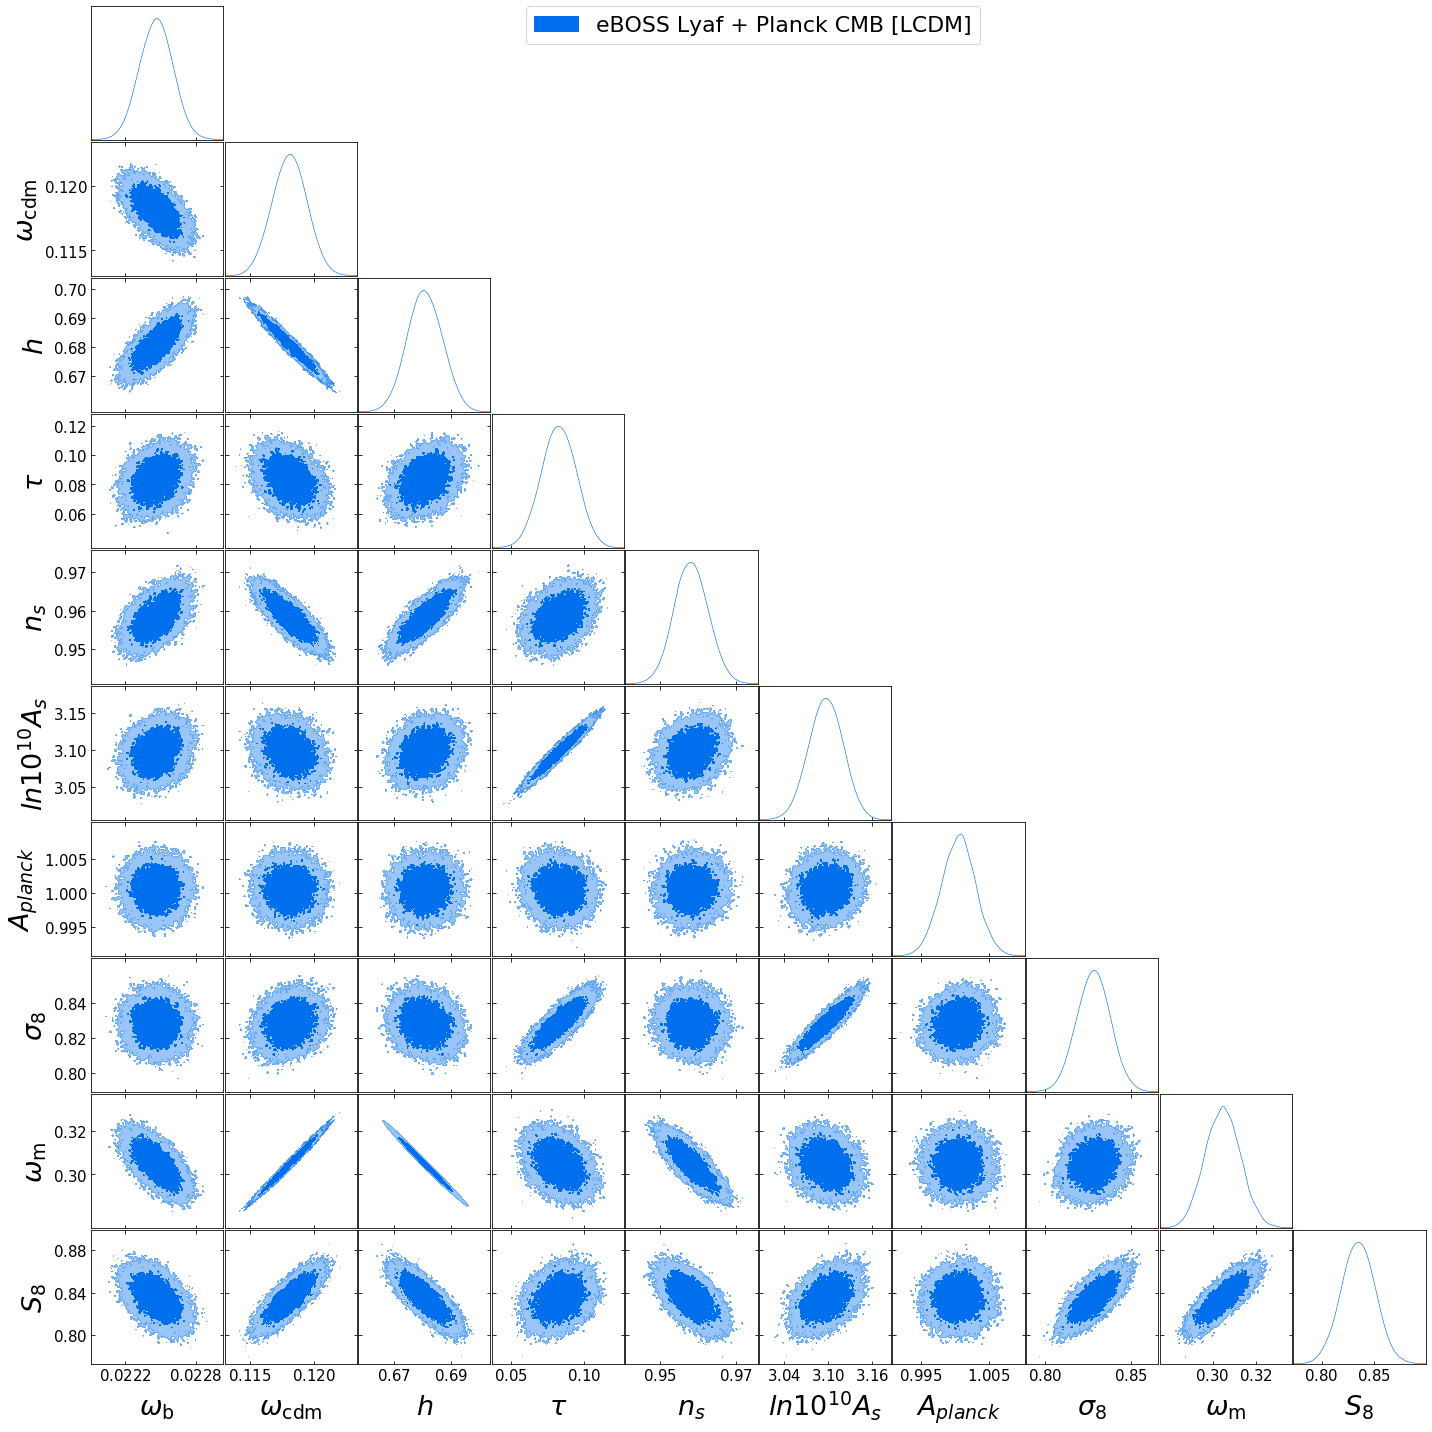

In [16]:
##LCDM
g.triangle_plot([mcsamples], filled=True, legend_labels=['eBOSS Lyaf + Planck CMB [LCDM]',])
#'AxionEmu+GPU sampler (ACT DR4 + WMAP TTTE; tau prior; m = 25)',])


In [ ]:
#Save MCMC samples
np.save('ACT_DR4_AxionEmu_m25_chain_100_20000_orig_emu.npy', chain_ax.numpy())


In [ ]:
#Load MCMC samples
chain_ax2 = np.load('ACT_DR6_Planck_TTTEEE_AxionEmu_LCDM_chain.npy')
burnin_steps2 = 200
samples_ax2 = chain_ax2[burnin_steps2:,:,:].reshape((-1, n_params_ax))


In [ ]:
##All axion masses
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"A_{planck}"]
labels = names
# mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##All axion masses
g.triangle_plot([mcsamples_ax], filled=True, legend_labels=['4e5 emulator+GPU sampler (Vary axion mass)'])

In [ ]:
##m = 1e-30 axion
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{Lambda}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s",
         #r"log 10^{32} ma",
         r"\omega_{\mathrm{ax}}",
         r"A_{planck}"]
labels = names
mcsamples = MCSamples(samples=samples_test, names = names, labels = labels)
mcsamples_ax = MCSamples(samples=samples_ax,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 25

In [ ]:
##m = 1e-30 axion
#g.triangle_plot([mcsamples, mcsamples_ax], filled=True, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-28)'])
g.triangle_plot([mcsamples], filled=True, legend_labels=['axionCAMB+EMCEE'])

In [ ]:
##m = 1e-30 axion
g.triangle_plot([mcsamples, mcsamples_ax], filled=False, legend_labels=['axionCAMB+EMCEE','4e5 emulator+GPU sampler (ma=1e-30)'])